In [1]:
import sys
sys.path.insert(1, '../')
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from agingml import temporal_degradation_test as tdt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_simulations = 1000
n_prod = 12
errors_df = pd.read_parquet(f'../results/aging/avocados/aging_avocados_{n_simulations}_simulations_{n_prod}_prod.parquet')
errors_df.head()

,y,y_pred,partition,timestamp,model_age,is_model_valid,simulation_id
timestamp,,,,,,,
2016-03-06,9.897642e+07,9.804857e+07,train,2016-03-06,-441,True,0
2016-03-13,9.903866e+07,9.902241e+07,train,2016-03-13,-434,True,0
2016-03-20,9.764452e+07,9.906663e+07,train,2016-03-20,-427,True,0
2016-03-27,9.159912e+07,9.530153e+07,train,2016-03-27,-420,True,0
2016-04-03,1.000183e+08,1.007825e+08,train,2016-04-03,-413,True,0


In [3]:
n_valid_models = errors_df[['simulation_id', 'is_model_valid']].drop_duplicates()['is_model_valid'].sum()
print(f"There are {n_valid_models} valid models out of {n_simulations} simulations.")

There are 909 valid models out of 1000 simulations.


In [4]:
d_errors_df = pd.read_parquet(f'../results/aging/avocados/aging_avocados_{n_simulations}_simulations_{n_prod}_prod_W.parquet')
# d_errors_df = d_errors_df[d_errors_df['is_model_valid'] == True]
d_errors_df.head()

,partition,simulation_id,timestamp,error,last_val_date,model_age,is_model_valid,error_rel
0,train,0,2016-03-06,0.009374,2017-05-21,-63.0,True,0.192776
1,train,0,2016-03-13,0.000164,2017-05-21,-62.0,True,0.003373
2,train,0,2016-03-20,0.014564,2017-05-21,-61.0,True,0.299502
3,train,0,2016-03-27,0.040420,2017-05-21,-60.0,True,0.831198
4,train,0,2016-04-03,0.007641,2017-05-21,-59.0,True,0.157137


In [5]:
test_errors_df = errors_df[errors_df['partition'] == 'test']
test_mape = test_errors_df.groupby('simulation_id').apply(lambda group: mean_absolute_percentage_error(group.y, group.y_pred))
test_mape = pd.DataFrame(test_mape, columns=['test_mape']).reset_index()

d_errors_df = pd.merge(d_errors_df, test_mape, how='left', on='simulation_id')

In [6]:
d_errors_df = d_errors_df[d_errors_df['test_mape'] <= 0.1]

In [7]:
d_errors_df

,partition,simulation_id,timestamp,error,last_val_date,model_age,is_model_valid,error_rel,test_mape
0,train,0,2016-03-06,0.009374,2017-05-21,-63.0,True,0.192776,0.017818
1,train,0,2016-03-13,0.000164,2017-05-21,-62.0,True,0.003373,0.017818
2,train,0,2016-03-20,0.014564,2017-05-21,-61.0,True,0.299502,0.017818
3,train,0,2016-03-27,0.040420,2017-05-21,-60.0,True,0.831198,0.017818
4,train,0,2016-04-03,0.007641,2017-05-21,-59.0,True,0.157137,0.017818
...,...,...,...,...,...,...,...,...,...
109944,prod,999,2017-12-24,0.247985,2016-12-04,55.0,True,5.099602,0.095514
109945,prod,999,2017-12-31,0.164837,2016-12-04,56.0,True,3.389729,0.095514
109946,prod,999,2018-01-07,0.176088,2016-12-04,57.0,True,3.621109,0.095514
109947,prod,999,2018-01-14,0.265416,2016-12-04,58.0,True,5.458057,0.095514


In [8]:
trend_lines_df = tdt.get_trend_lines(data=d_errors_df, quantiles=[0.25, 0.50, 0.75], metric='error')

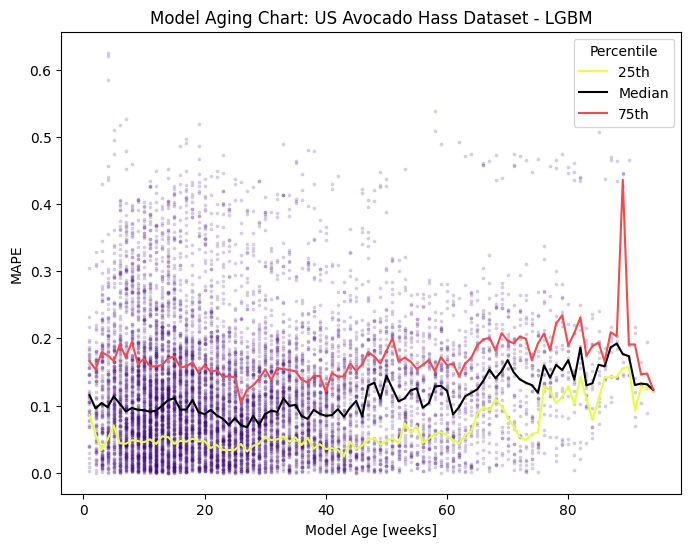

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data=trend_lines_df, x='model_age', y='error', linewidth=1.5,
             palette=['#E8FF3A', 'black', '#FB4748'], hue='quantile', legend=False, ax=ax)

sns.scatterplot(data=d_errors_df[d_errors_df['partition'] == 'prod'],
                x='model_age', y='error', s=7, alpha=0.20, color='#3b0280', linewidth=0, ax=ax)

ax.legend(title='Percentile', labels=['25th', 'Median', '75th'])
ax.set_xlabel('Model Age [weeks]')
ax.set_ylabel('MAPE')
# ax.set_ylim(0, 1)

ax.set_title('Model Aging Chart: US Avocado Hass Dataset - LGBM')
# plt.savefig('../figures/sketch_age_chart_calhouse_lgbm_MAPE.svg', format='svg')
plt.show()
